# Identifying temporal variation in EvoDevo data with MEFISTO

This notebook demonstrates how temporal (or spatial) covariates can be used for multimodal data integration to learn smooth latent factors using a developmental gene expression atlas comprising multiple species and organs.

Please find more information about this method — *MEFISTO* — [on its website](https://biofam.github.io/MOFA2/MEFISTO) and [in the preprint](https://www.biorxiv.org/content/10.1101/2020.11.03.366674v1) by Britta Velten et al.

A R version of the tutorial is available [here](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/evodevo_tutorial.html).

In [1]:
import numpy as np
import pandas as pd
from mofapy2.run.entry_point import entry_point
import mofax
import seaborn as sns

# initialise the entry point
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


## Load data

First we will load the evodevo data containing normalized gene expression data for 5 species (groups) and 5 organs (views) as well as the developmental time information for each sample. The data as well as a pre-trained model can be downloaded [from here](https://figshare.com/s/242916198fde3353f3e6).

In [2]:
datadir = "data/evodevo"

In [3]:
data = pd.read_csv(f"{datadir}/evodevo.csv", sep=",", index_col=0)
data

,group,view,sample,feature,value,time
1,Human,Brain,10wpc_Human,ENSG00000000457_Brain,8.573918,7
2,Human,Brain,10wpc_Human,ENSG00000001084_Brain,8.875957,7
3,Human,Brain,10wpc_Human,ENSG00000001167_Brain,11.265237,7
4,Human,Brain,10wpc_Human,ENSG00000001461_Brain,7.374965,7
5,Human,Brain,10wpc_Human,ENSG00000001561_Brain,7.311018,7
...,...,...,...,...,...,...
3193836,Human,Testis,youngMidAge_Human,ENSG00000271503_Testis,1.178014,21
3193837,Human,Testis,youngMidAge_Human,ENSG00000271601_Testis,1.178014,21
3193838,Human,Testis,youngMidAge_Human,ENSG00000272442_Testis,4.476201,21
3193839,Human,Testis,youngMidAge_Human,ENSG00000272886_Testis,1.178014,21


## Prepare and train MEFISTO

Next we create a MOFA object with this data with the default options.

In [4]:
ent.set_data_options()
ent.set_data_df(data)



Loaded group='Human' view='Brain' with N=23 samples and D=7696 features...
Loaded group='Human' view='Cerebellum' with N=23 samples and D=7696 features...
Loaded group='Human' view='Heart' with N=23 samples and D=7696 features...
Loaded group='Human' view='Liver' with N=23 samples and D=7696 features...
Loaded group='Human' view='Testis' with N=23 samples and D=7696 features...
Loaded group='Mouse' view='Brain' with N=14 samples and D=7696 features...
Loaded group='Mouse' view='Cerebellum' with N=14 samples and D=7696 features...
Loaded group='Mouse' view='Heart' with N=14 samples and D=7696 features...
Loaded group='Mouse' view='Liver' with N=14 samples and D=7696 features...
Loaded group='Mouse' view='Testis' with N=14 samples and D=7696 features...
Loaded group='Opossum' view='Brain' with N=15 samples and D=7696 features...
Loaded group='Opossum' view='Cerebellum' with N=15 samples and D=7696 features...
Loaded group='Opossum' view='Heart' with N=15 samples and D=7696 features...


We can now specify additional option for the model and the training. See our [basic python tutorial on MOFA](https://github.com/bioFAM/mofapy2/blob/master/mofapy2/notebooks/getting_started_python.ipynb)  for details. Here we specify, that we want to use 5 factor.

In [5]:
ent.set_model_options(factors=5)
ent.set_train_options()

Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (Brain): gaussian
- View 1 (Cerebellum): gaussian
- View 2 (Heart): gaussian
- View 3 (Liver): gaussian
- View 4 (Testis): gaussian




So far, we have not yet added the time information for the samples. This is done in the next step, where we also specify options for MEFISTO. In particular, we want to align time points between species and set `warp` to True using Mouse as reference. To also infer relationships between species we set `model_groups` to True.

In [6]:
times = [data[['sample', 'time', 'group']].drop_duplicates().set_index('sample').loc[np.concatenate(ent.data_opts['samples_names'])].query('group == @g').time.values.reshape(-1, 1) for g in ent.data_opts['groups_names']]
idx = np.where(ent.data_opts['groups_names'] == 'Mouse')

In [7]:
idx = ent.data_opts['groups_names'].index("Mouse")

In [8]:
ent.set_covariates(times, covariates_names="time")
ent.set_smooth_options(warping=True, warping_ref = idx, model_groups = True)

Loaded 1 covariate(s) for each sample...


Smooth covariate framework is activated. This is not compatible with ARD prior on factors. Setting ard_factors to False...

##
## Warping set to True: aligning the covariates across groups
##


Now we are ready to use MEFISTO with this object and save the results in a speciefied location. As this can take up to 15min, we provide a pre-trained model below.

In [9]:
ent.build()
# ent.run()
## To interpolate factor values
# ent.predict_factor(new_covariates=np.arange(1, 15).reshape(-1, 1))
# ent.save("evodevo_model.hdf5")

## Downstream analysis

For downstream analysis we can either use R (package [MOFA2](https://github.com/bioFAM/MOFA2)) or the Python package [mofax](https://github.com/bioFAM/mofax). Here we will proceed in Python and first load the pre-trained model generated by the above steps.

In [10]:
m = mofax.mofa_model(f"{datadir}/evodevo_model.hdf5")
m

MOFA+ model: evodevo model
Samples (cells): 83
Features: 38480
Groups: Human (23), Mouse (14), Opossum (15), Rabbit (15), Rat (16)
Views: Brain (7696), Cerebellum (7696), Heart (7696), Liver (7696), Testis (7696)
Factors: 5
Expectations: Sigma, W, Z

MEFISTO:
Covariates available: time
Interpolated factors for 14 new values

Groups correspond to species here and views correspond to organs:

In [11]:
print(f"""\
Samples: {m.shape[0]}
Features: {m.shape[1]}
Species: {', '.join(m.groups)}
Organs: {', '.join(m.views)}
""")

Samples: 83
Features: 38480
Species: Human, Mouse, Opossum, Rabbit, Rat
Organs: Brain, Cerebellum, Heart, Liver, Testis



### Variance explained

First, we can take a look at the variance explained by each of the inferred factors per organ and species.

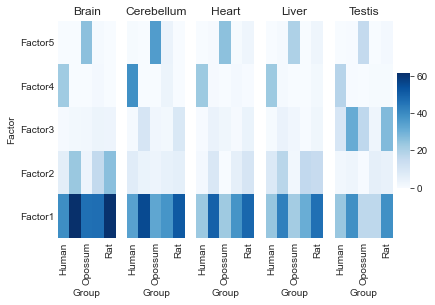

In [12]:
mofax.plot_r2(m, cmap="Blues")

### Visualization in the factor space

Using the first two factors, we can project the samples into a 2-dimensional space.

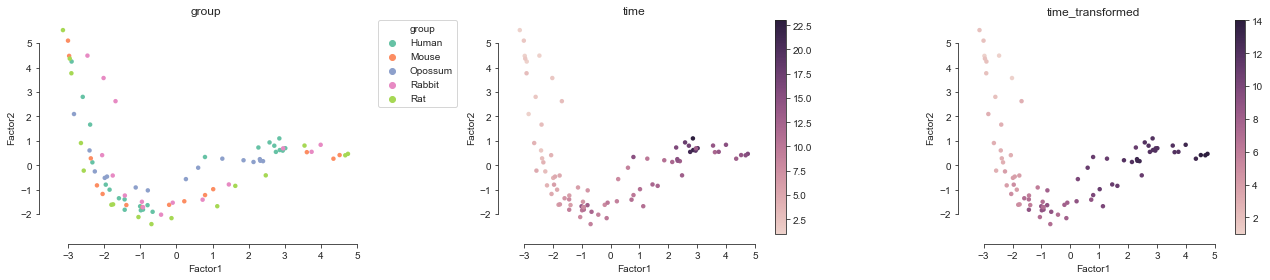

In [13]:
mofax.plot_factors_scatter(m, x=0, y=1, color=["group", "time", "time_transformed"]);

## Latent factors versus common developmental time

We can plot the latent processes along the inferred common developmental time.

Before alignment:

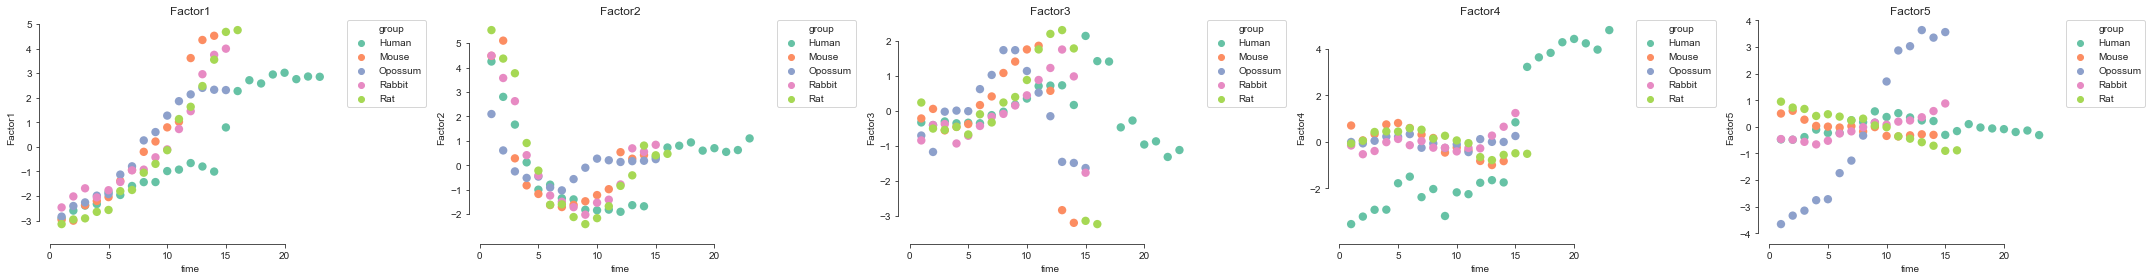

In [14]:
mofax.plot_factors_scatter(m, x="time", y=range(m.nfactors), 
                           ncols=5, size=70);

After alignment:

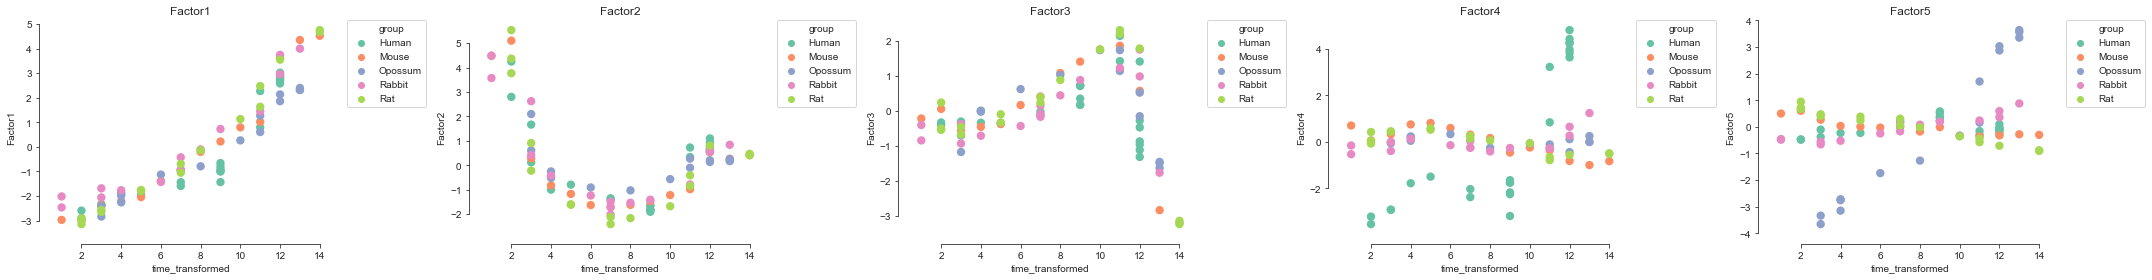

In [15]:
mofax.plot_factors_scatter(m, x="time_transformed", y=range(m.nfactors), 
                           ncols=5, size=70);

### Interpolation

Using the underlying Gaussian process for each factor we can interpolate to unseen time points for species that are missing data in these time points or intermediate time points.

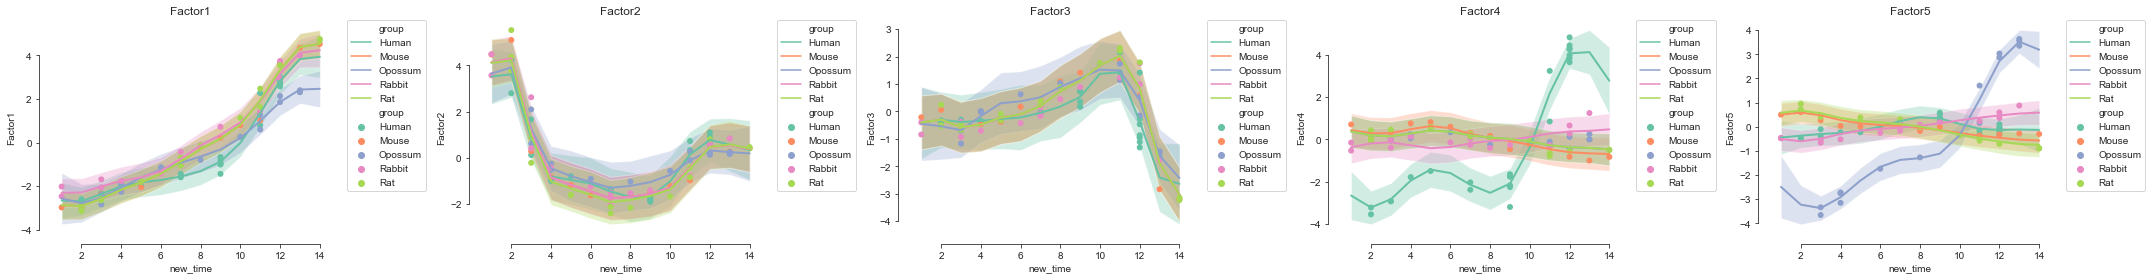

In [16]:
mofax.plot_interpolated_factors(m, factors=range(m.nfactors),
                                ncols=5, size=70);

Uncertainties and observed data points on these plots can be hidden with `only_mean=True` and `show_observed=False`:

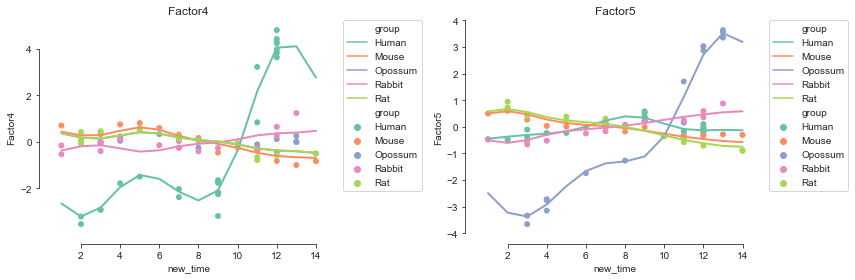

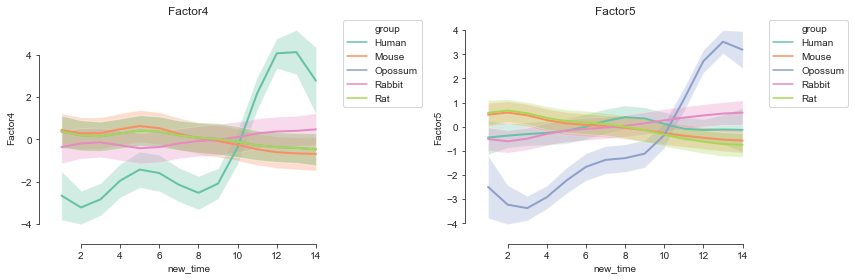

In [17]:
mofax.plot_interpolated_factors(m, factors=["Factor4", "Factor5"], size=70, only_mean=True);

mofax.plot_interpolated_factors(m, factors=["Factor4", "Factor5"], size=70, show_observed=False);

## Alignment

We can also take a look at the learnt alignemnt.

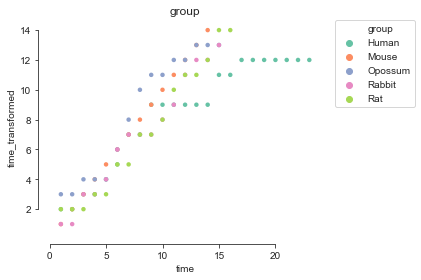

In [18]:
mofax.plot_factors_scatter(m, x="time", y="time_transformed");

## Smoothness and sharedness of factors

In addition to the factor values and the alignment the model also inferred an underlying Gaussian process that generated these values. By looking into it we can extract information on the smoothness of each factor, i.e. how smoothly it varies along developmental time, as well as the sharedness of each factor, i.e. how much the species (groups) show the same underlying developmental pattern and how the shape of their developmental trajectory related to a given developmental module (Factor) clusters between species.

### Smoothness

The scale parameters of the Gaussian process capture the smoothness of the model. We will visualize them with bar plots where more colour means more smoothness:

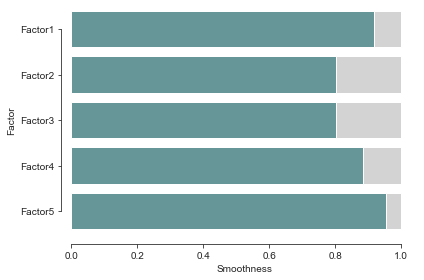

In [19]:
mofax.plot_smoothness(m);

### Sharedness

The group kernel of the Gaussian process can give us insights into the extent to which a temporal pattern is shared across species for the developmental module captured by each process.

First factors (factors 1, 2, and 3) seem to describe processed conserved across species while the last two factors show species-specific clusters:

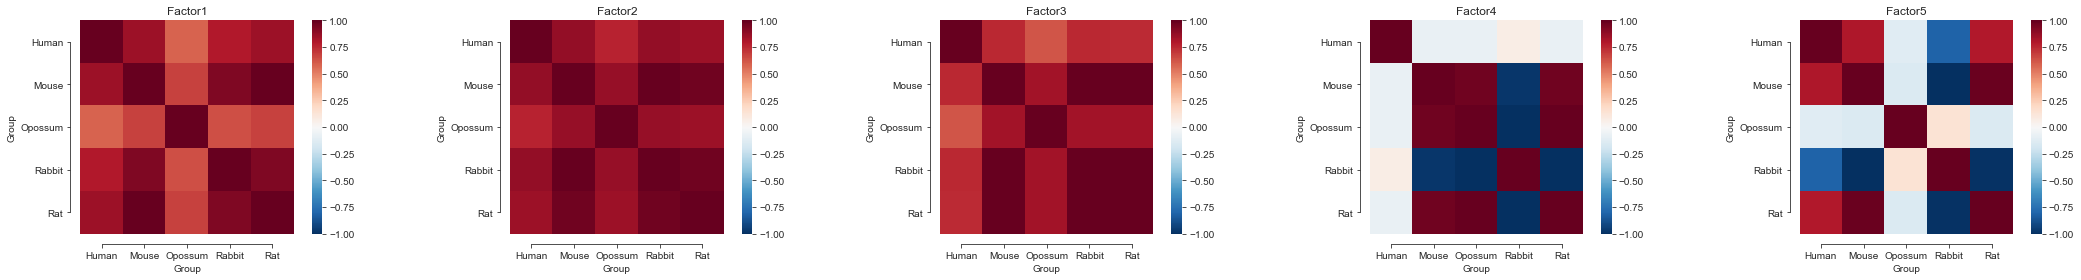

In [20]:
mofax.plot_group_kernel(m, ncols=5);

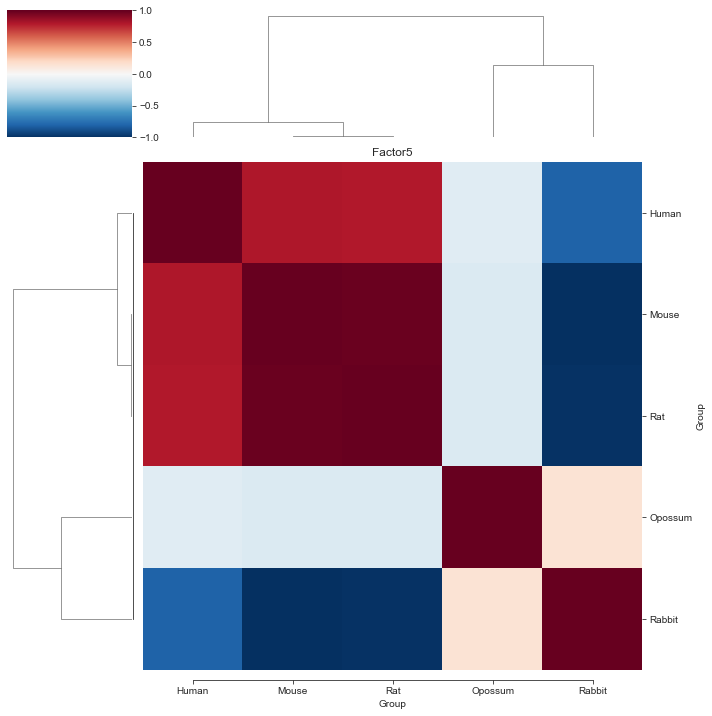

In [21]:
mofax.plot_group_kernel(m, ncols=5, factors="Factor5");

We plots overall sharedness of factors with a barplot where a fully coloured bar corresponds to a fully shared factor:

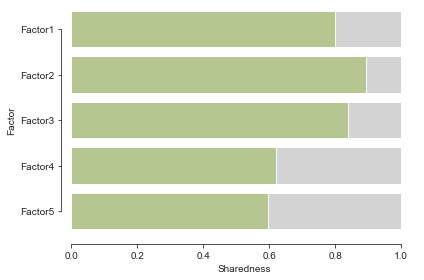

In [22]:
mofax.plot_sharedness(m);

### Weights

To gain insights into the molecular signatures underlying each factor, we can investigate the weights of each factor.

<AxesSubplot:title={'center':'Brain'}, xlabel='factor', ylabel='feature'>

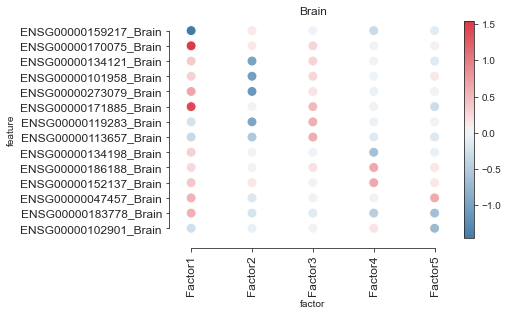

In [23]:
mofax.plot_weights_dotplot(m, view="Brain", n_features=3, 
                           yticklabels_size=12, xticklabels_size=12, size=100)

<AxesSubplot:title={'center':'Testis'}, xlabel='factor', ylabel='feature'>

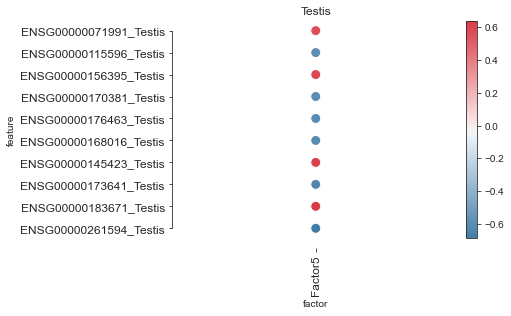

In [24]:
mofax.plot_weights_dotplot(m, view="Testis", n_features=10, factors=4,
                           yticklabels_size=12, xticklabels_size=12, size=100)

## Further analyses

Further down-stream analyses such as gene set enrichment analysis (GSEA) can be found in our [R tutorial](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/evodevo_tutorial.html), and of course custom analysis can be performed using the inferred weights and factors.